In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import time
import sys, os
os.chdir('../')

from tqdm import tqdm

from fashion_dataset.fashion_mnist_reader import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import *

In [1]:
import os 
os.getcwd()

'c:\\Users\\Sangjin\\DL_scratch\\Project'

In [7]:
import os

os.chdir('/Users/Sangjin/DL_scratch/')

In [3]:
x_train, y_train = load_mnist(path='fashion_dataset/', kind='train')

x_test, y_test = load_mnist(path='fashion_dataset/', kind='t10k')

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

x_train shape: (60000, 784), y_train shape: (60000,)
x_test shape: (10000, 784), y_test shape: (10000,)


In [4]:
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")

x_train = x_train.reshape(x_train.shape[0], 28, 28)
x_test = x_test.reshape(x_test.shape[0], 28, 28)

# Print the number of training and test datasets
print(f'{x_train.shape[0]} train set')
print(f'{x_test.shape[0]} test set')

# Define the text labels
fashion_mnist_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Sneaker",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9

x_train shape: (60000, 784), y_train shape: (60000,)
60000 train set
10000 test set


In [5]:
# Create a dictionary for each type of label 
labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

def get_classes_distribution(data, normalize=False):
    # Get the count for each label
    data = pd.Series(data).map(labels)
    label_counts = data.value_counts()

    return label_counts

get_classes_distribution(y_train)

Ankle Boot     6000
T-shirt/top    6000
Dress          6000
Pullover       6000
Sneaker        6000
Sandal         6000
Trouser        6000
Shirt          6000
Coat           6000
Bag            6000
dtype: int64

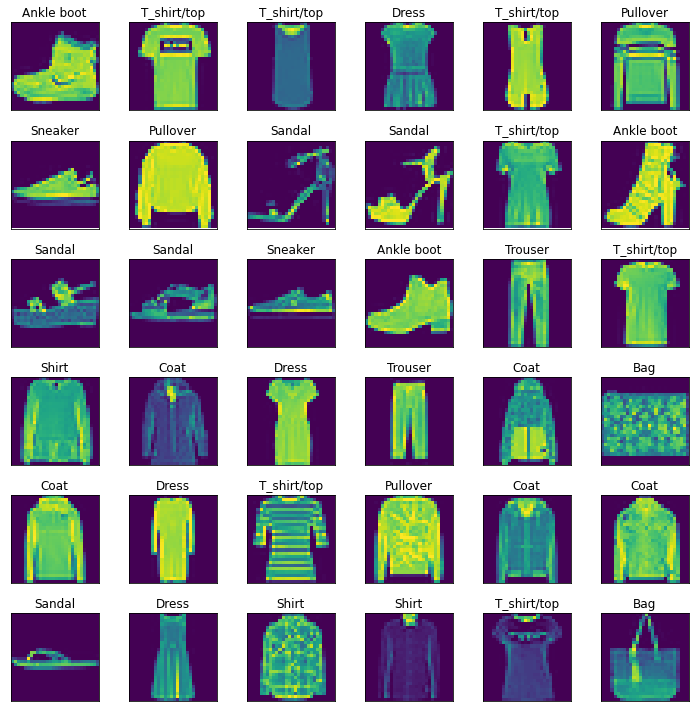

In [6]:
class_names = ['T_shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10, 10))

for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i].reshape((28,28)))
    label_index = int(y_train[i])
    plt.title(class_names[label_index])

plt.tight_layout()
plt.show()

In [7]:
result = pd.DataFrame(columns=['hidden_size_list', 'activation', 'weight_init_std', 'weight_decay_lambda', 
                                'use_dropout', 'dropout_ratio', 'use_batchnorm', 'iters_num', 'batch_size', 
                                'learning_rate', 'optimizer', 'train_acc', 'test_acc', 'time'])

In [8]:
# layers.py에 추가 완료.
class Alpha2Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = (np.random.rand(*x.shape) > self.dropout_ratio)
            return x * self.mask * (1 - self.dropout_ratio)
        else:
            return x * (1 - self.dropout_ratio)

    def backward(self, dout):
        return (dout / (1 - self.dropout_ratio)) * self.mask

In [9]:
# layers.py에 추가 완료.
import numpy as np

class ELU:
    """Exponential Linear Unit (ELU) activation function for neural networks.

    This class represents the ELU activation function used in neural networks.
    It has forward and backward methods to perform forward and backward passes.

    Attributes:
        alpha (float): The alpha parameter controlling the slope of the negative region.
        input (numpy.ndarray): The input data saved during the fowrad pass.
    """
    def __init__(self, alpha: float=1.0):
        """Initializes the ELU activation function with the given alpha parameter.

        Args:
            alpha (float, optional): The alpha parameter controlling the slope of negative region. Defaults to 1.0.
        """
        self.alpha = alpha
        self.input = None

    def forward(self, x: np.ndarray) -> np.ndarray:
        """Perform forward pass and return the result of ELU activation.

        Args:
            x (numpy.ndarray): The input array.

        Returns:
            numpy.ndarray: The result of the ELU activation.
        """
        self.input = x
        out = np.where(x > 0, x, self.alpha * (np.exp(x) - 1))
        return out

    def backward(self, dout: np.ndarray) -> np.ndarray:
        """Perform backward pass and return the gradient with respect to the input.

        Args:
            dout (numpy.ndarray): The gradient from the next layer.

        Returns:
            numpy.ndarray: The gradient with respect to the input.
        """
        dx = dout * np.where(self.input > 0, 1, self.alpha * np.exp(self.input))
        return dx


In [10]:
# layers.py에 추가완료.
class Selu_tmp:
    """Scaled Exponential Linear Unit (SeLU) activation function for neural networks.

    This class represents the SeLU activation function used in neural networks.
    It has forward and backward methods to perform forward and backward passes.

    Attributes:
        alpha (float): Slope of the negative region.
        scale (float): Scaling factor for the output.
        mask (numpy.ndarray): A boolean mask indicating the locations where the input is less than or equal to 0.
    """
    def __init__(self, alpha=1.67326, scale=1.0507):
        self.alpha = alpha
        self.scale = scale
        self.mask = None
        self.input_data = None

    def forward(self, x: np.ndarray) -> np.ndarray:
        """Perform forward pass and return the result of SeLU activation.

        Args:
            x (numpy.ndarray): The input array.

        Returns:
            numpy.ndarray: The result of the SeLU activation.
        """
        self.mask = (x <= 0)
        self.input_data = x
        out = self.scale * np.where(x > 0, x, self.alpha * (np.exp(np.clip(x, -700, 700)) - 1))
        return out

    def backward(self, dout: np.ndarray) -> np.ndarray:
        """Perform backward pass and return the gradient with respect to the input.

        Args:
            dout (numpy.ndarray): The gradient from the next layer.

        Returns:
            numpy.ndarray: The gradient with respect to the input.
        """
        dx_pos = dout * self.scale * np.where(self.input_data > 0, 1, 0)
        dx_neg = dout * self.scale * self.alpha * np.exp(np.clip(self.input_data, -700, 700)) * np.where(self.input_data <= 0, 1, 0)
        dx = dx_pos + dx_neg
        return dx


In [31]:
# multi_layer_net_extend.py
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient

class MultiLayerNetExtend:
    """
    Multi-layer neural network with extended features such as batch normalization, dropout, and weight decay.

    Args:
        input_size (int): Size of the input layer.
        hidden_size_list (list): List of integers representing the sizes of hidden layers.
        output_size (int): Size of the output layer.
        activation (str, optional): Activation function for hidden layers. Defaults to 'relu'.
        weight_init_std (str or float, optional): Standard deviation for weight initialization.
            If 'relu' or 'he' is provided, it uses a scale factor for ReLU. If 'sigmoid' or 'xavier' is provided,
            it uses a scale factor for Sigmoid. Defaults to 'relu'.
        weight_decay_lambda (float, optional): Strength of L2 regularization (weight decay). Defaults to 0.
        use_dropout (bool, optional): Flag to use dropout regularization. Defaults to False.
        dropout_ration (float, optional): Dropout ratio if use_dropout is True. Defaults to 0.5.
        use_batchnorm (bool, optional): Flag to use batch normalization. Defaults to False.

    Attributes:
        input_size (int): Size of the input layer.
        output_size (int): Size of the output layer.
        hidden_size_list (list): List of integers representing the sizes of hidden layers.
        hidden_layer_num (int): Number of hidden layers.
        use_dropout (bool): Flag to use dropout regularization.
        weight_decay_lambda (float): Strength of L2 regularization (weight decay).
        use_batchnorm (bool): Flag to use batch normalization.
        params (dict): Dictionary to store network parameters (weights and biases).
        layers (OrderedDict): Ordered dictionary to store network layers in sequence.
        last_layer (SoftmaxWithLoss): Softmax with Loss layer for the output layer.
    """
    def __init__(self, input_size:int, hidden_size_list: list, output_size: int,
                 activation: str = 'relu', weight_init_std: str or float = 'relu', weight_decay_lambda: float = 0, 
                 use_dropout: bool = False, dropout_ratio: float = 0.5, use_batchnorm: bool = False):
        """
        Initialize the MultiLayerNetExtend.

        Args are used to set up the architecture of the neural network and its training parameters.
        Weights and biases are initialized based on the provided weight_init_std.

        Parameters:
            input_size (int): Size of the input layer.
            hidden_size_list (list): List of integers representing the sizes of hidden layers.
            output_size (int): Size of the output layer.
            activation (str, optional): Activation function for hidden layers. Defaults to 'relu'.
            weight_init_std (str or float, optional): Standard deviation for weight initialization.
                If 'relu' or 'he' is provided, it uses a scale factor for ReLU.
                If 'sigmoid' or 'xavier' is provided, it uses a scale factor for Sigmoid.
                Defaults to 'relu'.
            weight_decay_lambda (float, optional): Strength of L2 regularization (weight decay). Defaults to 0.
            use_dropout (bool, optional): Flag to use dropout regularization. Defaults to False.
            dropout_ration (float, optional): Dropout ratio if use_dropout is True. Defaults to 0.5.
            use_batchnorm (bool, optional): Flag to use batch normalization. Defaults to False.
        """
        # Initialization of network parameters
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.activation = activation
        self.weight_init_std = weight_init_std,
        self.weight_decay_lambda = weight_decay_lambda
        self.use_dropout = use_dropout
        self.dropout_ratio = dropout_ratio
        self.use_batchnorm = use_batchnorm
        self.hidden_layer_num = len(hidden_size_list)
        self.params = {}

        # Weight initialization
        self.__init_weight(weight_init_std)

        # Activation layer based on the specified activation function
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu, 'selu': Selu, 'elu': ELU}
        self.layers = OrderedDict()
        
        # Hidden layers
        for idx in range(1, self.hidden_layer_num + 1):
            self.layers[f'Affine{idx}'] = Affine(self.params[f'W{idx}'], self.params[f'b{idx}'])
            if self.use_batchnorm:
                self.params[f'gamma{idx}'] = np.ones(hidden_size_list[idx-1])
                self.params[f'beta{idx}'] = np.zeros(hidden_size_list[idx-1])
                self.layers[f'BatchNorm{idx}'] = BatchNormalization(self.params[f'gamma{idx}'], self.params[f'beta{idx}'])
            self.layers[f'Activation_function{idx}'] = activation_layer[activation]()

            # Dropout layer
            if self.use_dropout:
                self.layers[f'Dropout{idx}'] = AlphaDropout(dropout_ratio)

        # Output layer
        idx = self.hidden_layer_num + 1
        self.layers[f'Affine{idx}'] = Affine(self.params[f'W{idx}'], self.params[f'b{idx}'])

        # Softmax with Loss layer for the output
        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std: str or float):
        """
        Initialize weights and biases for each layer based on the specified weight initialization method.

        Args:
            weight_init_std (str or float): Standard deviation for weight initialization.
                If 'relu' or 'he' is provided, it uses a scale factor for ReLU.
                If 'sigmoid' or 'xavier' is provided, it uses a scale factor for Sigmoid.
                If a float is provided, it uses that value as the standard deviation.
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]

        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he', 'elu'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier', 'selu'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])

            self.params[f'W{idx}'] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params[f'b{idx}'] = np.zeros(all_size_list[idx])

    def predict(self, x: np.array, train_flg: bool = False) -> np.array:
        """
        Forward pass to make predictions.

        Args:
            x (np.array): Input data.
            train_flg (bool, optional): Flag indicating whether the model is in training mode. Defaults to False.

        Returns:
            np.array: Predicted output.
        """
        for layer in self.layers.values():
            if "Dropout" in layer.__class__.__name__ or "BatchNorm" in layer.__class__.__name__:
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)

        return x

    def loss(self, x: np.array, t: np.array, train_flg: bool = False) -> float:
        """
        Compute the loss.

        Args:
            x (np.array): Input data.
            t (np.array): Ground truth labels.
            train_flg (bool, optional): Flag indicating whether the model is in training mode. Defaults to False.

        Returns:
            float: Loss value.
        """
        y = self.predict(x, train_flg)

        # Weight decay term
        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params[f'W{idx}']
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)

        # Cross-entropy loss + Weight decay
        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, X: np.array, T: np.array) -> float:
        """
        Compute the accuracy of the model on the given data.

        Args:
            X (np.array): Input data.
            T (np.array): Ground truth labels.

        Returns:
            float: Accuracy.
        """
        Y = self.predict(X, train_flg=False)
        Y = np.argmax(Y, axis=1)
        if T.ndim != 1:
            T = np.argmax(T, axis=1)

        accuracy = np.sum(Y == T) / float(X.shape[0])
        return accuracy

    def numerical_gradient(self, X: np.array, T: np.array) -> float:
        """
        Compute the numerical gradient of the loss with respect to the parameters.

        Args:
            X (np.array): Input data.
            T (np.array): Ground truth labels.

        Returns:
            dict: Dictionary containing numerical gradients for each parameter.
        """
        loss_W = lambda W: self.loss(X, T, train_flg=True)

        grads = {}
        for idx in range(1, self.hidden_layer_num + 2):
            grads[f'W{idx}'] = numerical_gradient(loss_W, self.params[f'W{idx}'])
            grads[f'b{idx}'] = numerical_gradient(loss_W, self.params[f'b{idx}'])

            if self.use_batchnorm and idx != self.hidden_layer_num + 1:
                grads[f'gamma{idx}'] = numerical_gradient(loss_W, self.params[f'gamma{idx}'])
                grads[f'beta{idx}'] = numerical_gradient(loss_W, self.params[f'beta{idx}'])

        return grads

    def gradient(self, x: np.array, t: np.array) -> dict:
        """
        Compute the gradient of the loss with respect to the parameters using backpropagation.

        Args:
            x (np.array): Input data.
            t (np.array): Ground truth labels.

        Returns:
            dict: Dictionary containing gradients for each parameter.
        """
        # Forward pass and loss computation
        self.loss(x, t, train_flg=True)

        # Backward pass
        dout = 1
        dout = self.last_layer.backward(dout)

        # Reverse the order of layers for backward pass
        layers = list(self.layers.values())
        layers.reverse()

        # Backward pass through all layers
        for layer in layers:
            dout = layer.backward(dout)

        # Compute gradients for each parameter
        grads = {}
        for idx in range(1, self.hidden_layer_num + 2):
            grads[f'W{idx}'] = self.layers[f'Affine{idx}'].dW + self.weight_decay_lambda * self.params[f'W{idx}']
            grads[f'b{idx}'] = self.layers[f'Affine{idx}'].db

            if self.use_batchnorm and idx != self.hidden_layer_num + 1:
                grads[f'gamma{idx}'] = self.layers[f'BatchNorm{idx}'].dgamma
                grads[f'beta{idx}'] = self.layers[f'BatchNorm{idx}'].dbeta

        return grads

In [32]:
# regularization.py에 추가완료.
def one_cycle_lr_schedule(iteration, max_lr, total_iterations, warmup_fraction=0.1):
    warmup_iterations = int(total_iterations * warmup_fraction)
    
    if iteration < warmup_iterations:
        return max_lr * iteration / warmup_iterations
    
    cycle_iterations = total_iterations - warmup_iterations
    cycle_fraction = (iteration - warmup_iterations) / cycle_iterations
    return max_lr * (1 + np.cos(np.pi * cycle_fraction)) / 2

In [13]:
# optimizer.py에 추가완료.
class Nadam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for key in params.keys():
            # Update biased first moment estimate
            self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * grads[key]

            # Update biased second raw moment estimate
            self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * grads[key]**2

            # Compute the corrected first moment
            m_hat = self.m[key] / (1.0 - self.beta1**self.iter)

            # Compute the term taking into account the correction from the second moment estimate
            v_hat = self.v[key] / (1.0 - self.beta2**self.iter)

            # Update parameters
            params[key] -= lr_t * m_hat / (np.sqrt(v_hat) + 1e-7)

In [14]:
x_train.mean(), x_train.std()

(-7.9631286e-07, 1.0000011)

Learning progress:   0%|            | 3/10000 [00:01<54:05,  3.08it/s]

train acc, test acc | 0.156, 0.1534


Learning progress:  19%|=        | 1881/10000 [01:05<11:05, 12.19it/s]

train acc, test acc | 0.90815, 0.8762


Learning progress:  38%|===      | 3753/10000 [02:13<14:53,  6.99it/s]

train acc, test acc | 0.9340166666666667, 0.8884


Learning progress:  56%|=====    | 5629/10000 [03:21<06:35, 11.05it/s]

train acc, test acc | 0.9541833333333334, 0.8954


Learning progress:  75%|======   | 7505/10000 [04:24<03:42, 11.20it/s]

train acc, test acc | 0.969, 0.902


Learning progress:  94%|======== | 9379/10000 [05:30<00:54, 11.37it/s]

train acc, test acc | 0.9744833333333334, 0.9046


Learning progress: 100%|========| 10000/10000 [05:49<00:00, 28.59it/s]


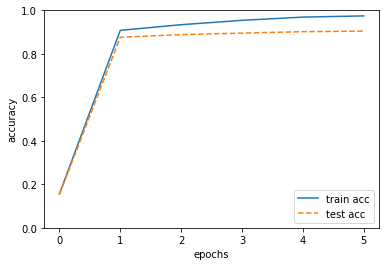

In [16]:
# seed 설정
np.random.seed(42)

# 데이터 읽기
x_train, t_train = load_mnist(path='fashion_dataset/', kind='train', normalize=True, one_hot_label=True)
x_test, t_test = load_mnist(path='fashion_dataset/', kind='t10k', normalize=True, one_hot_label=True)

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[256, 64], output_size=10, activation='selu', weight_init_std='selu', 
                              use_batchnorm=False, use_dropout=True, dropout_ratio=0.25, weight_decay_lambda=2.108559297476214e-06)

# 하이퍼파라미터
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 512   # 미니배치 크기
learning_rate = 0.2

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

optimizer = Momentum(lr=learning_rate)

start_time = time.time()

for i in tqdm(range(iters_num), desc='Learning progress', ncols=70, ascii=' =', leave=True):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch, t_batch = x_train[batch_mask], t_train[batch_mask]
    
    # 기울기 계산
    grad = network.gradient(x_batch, t_batch)
    
    lr = one_cycle_lr_schedule(i, max_lr=learning_rate, total_iterations=iters_num)
    optimizer.lr = lr
    optimizer.update(network.params, grad)

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print(f"train acc, test acc | {train_acc}, {test_acc}")

end_time = time.time()
training_time = end_time - start_time

# Assuming network is an instance of the MultiLayerNetExtend class
network_info = {
    'hidden_size_list': network.hidden_size_list,
    'activation': network.layers['Activation_function1'].__class__.__name__.lower(),
    'weight_init_std': 'he' if network.layers['Activation_function1'].__class__.__name__.lower() in ('relu', 'elu') else 'xavier',
    'weight_decay_lambda': network.weight_decay_lambda,
    'use_dropout': network.use_dropout,
    'dropout_ratio': network.layers['Dropout1'].dropout_ratio if network.use_dropout else None,
    'use_batchnorm': network.use_batchnorm,
    'iters_num': iters_num,
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'optimizer': optimizer.__class__.__name__,
    'train_acc': network.accuracy(x_train, t_train),
    'test_acc': network.accuracy(x_test, t_test),
    'time': training_time 
}

result = pd.concat([result, pd.DataFrame([network_info])])

# 그래프 그리기
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

In [36]:
x_comp = np.load('./Project/test file/x_test.npy')
t_comp = np.load('./Project/test file/t_test.npy')

x_comp = x_comp.astype(np.float32)
x_comp = (x_comp - x_comp.mean()) / x_comp.std()

network.accuracy(x_comp, t_comp)

1.0

In [25]:
from keras.datasets import fashion_mnist

(x_train, t_train), (x_test, t_test) = fashion_mnist.load_data()

x_test = x_test.astype(np.float32).reshape(x_test.shape[0], -1)
x_test = (x_test - x_comp.mean()) / x_test.std()

network.accuracy(x_test, t_test)

0.8019

In [22]:
result

,hidden_size_list,activation,weight_init_std,weight_decay_lambda,use_dropout,dropout_ratio,use_batchnorm,iters_num,batch_size,learning_rate,optimizer,train_acc,test_acc,time
0,"[256, 64]",selu_tmp,xavier,0.000002,True,0.25,False,10000,512,0.2,Momentum,0.974467,0.9045,349.790528


In [75]:
final_model.predict(x_comp[[0]])

array([[-19.67192183,   9.16974   , -33.70212298, -27.5499361 ,
        -35.13290805,  39.85116428, -24.33165655,  48.93600895,
         -8.26660576,  96.28285811]])

In [73]:
t_comp[0]

9

In [74]:
network.accuracy(x_comp[[0]], t_comp[[0]])

1.0

In [89]:
final_model.accuracy(x_test, t_test)

0.772

In [96]:
network.accuracy(x_test, t_test)

0.8259

In [22]:
result

,hidden_size_list,activation,weight_init_std,weight_decay_lambda,use_dropout,dropout_ratio,use_batchnorm,iters_num,batch_size,learning_rate,optimizer,train_acc,test_acc,time
0,"[512, 256, 128]",relu,he,0,False,None,True,10000,512,0.010,Momentum,1.000000,0.8941,339.535543
0,"[512, 256, 128]",relu,he,0,False,None,True,10000,512,0.050,Momentum,1.000000,0.8933,346.346696
0,"[512, 256, 128]",relu,he,0,False,None,True,10000,512,0.005,Momentum,0.999167,0.8764,472.748453


In [194]:
result.to_csv('./result_1210_v3.csv')

In [193]:
result

,hidden_size_list,activation,weight_init_std,weight_decay_lambda,use_dropout,dropout_ratio,use_batchnorm,iters_num,batch_size,learning_rate,optimizer,train_acc,test_acc,time
0,"[512, 256, 128]",selu_tmp,xavier,0,True,0.25,True,10000,512,0.01,Momentum,0.982817,0.8991,950.107487
0,"[256, 128]",selu_tmp,xavier,0,True,0.25,False,10000,512,0.01,Momentum,0.978617,0.9057,346.187427
0,"[128, 64, 32]",selu_tmp,xavier,0,True,0.25,False,10000,512,0.01,Momentum,0.961483,0.8979,167.025283
0,"[64, 32]",selu_tmp,xavier,0,True,0.25,False,10000,512,0.01,Momentum,0.946317,0.8883,100.567107
0,"[128, 32]",selu_tmp,xavier,0,True,0.25,False,10000,512,0.01,Momentum,0.960133,0.8998,155.435449
0,"[128, 32]",selu_tmp,xavier,0,True,0.5,False,10000,512,0.01,Momentum,0.930950,0.8856,159.047593
0,"[256, 128]",selu_tmp,xavier,0,True,0.5,False,10000,512,0.01,Momentum,0.953050,0.8997,375.169375
0,"[256, 128]",selu_tmp,xavier,0,True,0.25,False,10000,256,0.01,Momentum,0.939933,0.8953,177.650481
0,"[256, 64]",selu_tmp,xavier,0,True,0.25,False,10000,512,0.01,Momentum,0.974417,0.9030,340.173420
0,"[256, 32]",selu_tmp,xavier,0,True,0.25,False,10000,512,0.01,Momentum,0.970800,0.9025,340.128564


In [13]:
result.to_csv('./result_1210.csv')

Learning progress: 100%|==========| 1000/1000 [01:43<00:00,  9.65it/s]


(train acc: 0.928375, valid acc: 0.8878333333333334) | weight decay: 6.020991903738259e-08


Learning progress: 100%|==========| 1000/1000 [01:52<00:00,  8.91it/s]


(train acc: 0.9253125, valid acc: 0.8860833333333333) | weight decay: 2.994715876079184e-06


Learning progress: 100%|==========| 1000/1000 [01:50<00:00,  9.06it/s]


(train acc: 0.9074166666666666, valid acc: 0.87625) | weight decay: 7.855914588019412e-06


Learning progress: 100%|==========| 1000/1000 [01:56<00:00,  8.61it/s]


(train acc: 0.9305208333333334, valid acc: 0.8918333333333334) | weight decay: 5.934726196444554e-07


Learning progress: 100%|==========| 1000/1000 [01:52<00:00,  8.88it/s]


(train acc: 0.9285416666666667, valid acc: 0.8868333333333334) | weight decay: 2.2167598465839503e-07


Learning progress: 100%|==========| 1000/1000 [01:54<00:00,  8.70it/s]


(train acc: 0.9209166666666667, valid acc: 0.881) | weight decay: 4.45563082275952e-08


Learning progress: 100%|==========| 1000/1000 [01:27<00:00, 11.47it/s]


(train acc: 0.9312291666666667, valid acc: 0.8920833333333333) | weight decay: 2.008200346026684e-07


Learning progress: 100%|==========| 1000/1000 [01:30<00:00, 11.01it/s]


(train acc: 0.9326875, valid acc: 0.8911666666666667) | weight decay: 2.007712765963896e-07


Learning progress: 100%|==========| 1000/1000 [01:55<00:00,  8.67it/s]


(train acc: 0.9197708333333333, valid acc: 0.88375) | weight decay: 1.393546942970559e-07


Learning progress: 100%|==========| 1000/1000 [01:50<00:00,  9.01it/s]


(train acc: 0.9257083333333334, valid acc: 0.8874166666666666) | weight decay: 2.6139565619750825e-07
=========== Hyper-Parameter Optimization Result ===========
Best-1(val acc:0.8920833333333333) | weight decay: 2.008200346026684e-07
Best-2(val acc:0.8918333333333334) | weight decay: 5.934726196444554e-07
Best-3(val acc:0.8911666666666667) | weight decay: 2.007712765963896e-07
Best-4(val acc:0.8878333333333334) | weight decay: 6.020991903738259e-08
Best-5(val acc:0.8874166666666666) | weight decay: 2.6139565619750825e-07
Best-6(val acc:0.8868333333333334) | weight decay: 2.2167598465839503e-07
Best-7(val acc:0.8860833333333333) | weight decay: 2.994715876079184e-06
Best-8(val acc:0.88375) | weight decay: 1.393546942970559e-07
Best-9(val acc:0.881) | weight decay: 4.45563082275952e-08
Best-10(val acc:0.87625) | weight decay: 7.855914588019412e-06


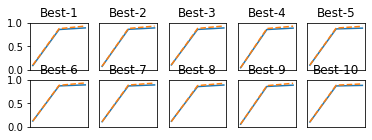

In [163]:
from common.util import shuffle_dataset
np.random.seed(42)

def random_hyperparams():
    # dropout_ratio = np.random.uniform(0.2, 0.5)
    weight_decay_lambda = 10 ** np.random.uniform(-8, -5)
    # return dropout_ratio, weight_decay_lambda
    return weight_decay_lambda

# def initialize_network(dropout_ratio, weight_decay_lambda):
def initialize_network(weight_decay_lambda):
    return MultiLayerNetExtend(
        input_size=784, hidden_size_list=[256, 32], output_size=10,
        activation='elu', weight_init_std='elu',
        use_batchnorm=True, use_dropout=False,weight_decay_lambda=weight_decay_lambda
    )

def train_network(network, x_train, t_train, x_val, t_val, iters_num=1000, batch_size=512):
    optimizer = Nadam(lr=0.01)
    iter_per_epoch = max(x_train.shape[0] / batch_size, 1)

    train_loss_list = []
    train_acc_list = []
    valid_acc_list = []

    for i in tqdm(range(iters_num), desc='Learning progress', ncols=70, ascii=' =', leave=True):
        batch_mask = np.random.choice(len(x_train), batch_size)
        x_batch, t_batch = x_train[batch_mask], t_train[batch_mask]

        grad = network.gradient(x_batch, t_batch)
        lr = one_cycle_lr_schedule(i, max_lr=0.2, total_iterations=iters_num)
        optimizer.lr = lr
        optimizer.update(network.params, grad)

        loss = network.loss(x_batch, t_batch)
        train_loss_list.append(loss)

        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            valid_acc = network.accuracy(x_val, t_val)
            train_acc_list.append(train_acc)
            valid_acc_list.append(valid_acc)

    return train_acc_list, valid_acc_list

def plot_results(results_train, results_val):
    print("=========== Hyper-Parameter Optimization Result ===========")
    graph_draw_num = 20
    col_num = 5
    row_num = int(np.ceil(graph_draw_num / col_num))
    i = 0

    for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
        print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

        plt.subplot(row_num, col_num, i+1)
        plt.title("Best-" + str(i+1))
        plt.ylim(0.0, 1.0)
        if i % 5: plt.yticks([])
        plt.xticks([])
        x = np.arange(len(val_acc_list))
        plt.plot(x, val_acc_list)
        plt.plot(x, results_train[key], "--")
        i += 1

        if i >= graph_draw_num:
            break

    plt.show()

# 데이터 로드 및 분할
x_train, t_train = load_mnist(path='fashion_dataset/', kind='train', normalize=True, one_hot_label=True)
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val, t_val = x_train[:validation_num], t_train[:validation_num]
x_train, t_train = x_train[validation_num:], t_train[validation_num:]

# 실험 횟수
num_experiments = 10
results_val = {}
results_train = {}

for _ in range(num_experiments):
    '''dropout_ratio, weight_decay_lambda = random_hyperparams()
    network = initialize_network(dropout_ratio, weight_decay_lambda)'''
    weight_decay_lambda = random_hyperparams()
    network = initialize_network(weight_decay_lambda)
    
    train_acc_list, valid_acc_list = train_network(network, x_train, t_train, x_val, t_val)
    
    # key = f"weight decay: {str(weight_decay_lambda)}, dropout_ratio: {str(dropout_ratio)}"
    key = f"weight decay: {str(weight_decay_lambda)}"
    
    results_val[key] = valid_acc_list
    results_train[key] = train_acc_list

    print(f'(train acc: {train_acc_list[-1]}, valid acc: {valid_acc_list[-1]}) | {key}')

plot_results(results_train, results_val)


In [ ]:
import numpy as np

def stratified_kfold(X, y, n_splits=5, shuffle=True, random_state=None):
    """
    Stratified K-Fold 교차 검증을 구현하는 함수
    
    Parameters:
    - X: 입력 데이터
    - y: 클래스 레이블
    - n_splits: 폴드의 개수
    - shuffle: 데이터를 섞을지 여부
    - random_state: 랜덤 시드 값
    
    Returns:
    - fold_indices: 폴드 인덱스를 담은 리스트 (각 폴드는 (train_indices, test_indices)로 구성)
    """
    if shuffle:
        np.random.seed(random_state)
        shuffled_indices = np.random.permutation(len(X))
        X, y = X[shuffled_indices], y[shuffled_indices]

    fold_indices = []
    unique_labels = np.unique(y)
    label_counts = {label: np.sum(y == label) for label in unique_labels}

    for i in range(n_splits):
        test_start = int(len(X) * i / n_splits)
        test_end = int(len(X) * (i + 1) / n_splits)

        test_indices = []
        for label in unique_labels:
            label_indices = np.where(y == label)[0]
            label_indices_in_fold = label_indices[(label_indices >= test_start) & (label_indices < test_end)]
            test_indices.extend(label_indices_in_fold)

        train_indices = np.setdiff1d(np.arange(len(X)), test_indices)
        fold_indices.append((train_indices, test_indices))

    return fold_indices

# 예제 데이터 생성
X = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13, 14], [15, 16]])
y = np.array([0, 1, 0, 1, 0, 1, 0, 1])

# Stratified K-Fold 교차 검증 수행
fold_indices = stratified_kfold(X, y, n_splits=4, shuffle=True, random_state=42)

# 결과 출력
for i, (train_indices, test_indices) in enumerate(fold_indices):
    print(f"Fold {i + 1}: Train indices={train_indices}, Test indices={test_indices}")


<hr>

In [33]:
import pickle

with open('./Project/net_chain.pkl', 'wb') as f:
    pickle.dump(network, f)

In [34]:
with open('./Project/net_chain_params.pkl', 'rb') as f:
    model_params = pickle.load(f)

In [35]:
model_params

{'W1': array([[ 8.02253612e-02,  2.54916435e-02,  1.26705712e-01, ...,
          7.92664277e-02,  4.40197920e-02, -5.99399902e-02],
        [ 1.06424878e-01,  9.87479753e-03,  1.19259488e-01, ...,
          1.39770211e-02,  1.05858173e-01, -4.52843021e-02],
        [ 5.03756702e-02,  2.27142431e-02,  8.59692660e-02, ...,
          2.09124723e-02,  9.02510807e-02,  1.53656721e-02],
        ...,
        [-5.11516975e-02, -3.11239806e-02,  1.16972284e-01, ...,
         -8.03849762e-02,  1.28882783e-01, -3.56281227e-01],
        [-2.32797309e-02, -4.44478238e-05,  7.72644003e-02, ...,
         -4.87912805e-02,  1.31267604e-01, -4.10157363e-02],
        [-6.95745107e-03,  1.03155806e-02,  1.39067688e-01, ...,
         -2.43764321e-02,  1.14153041e-01, -1.79368237e-02]]),
 'b1': array([-7.58091350e-02, -3.80231766e-02, -1.31287086e-01, -1.22671150e-01,
         1.54581961e-01, -1.05913939e-01, -7.34857581e-02, -1.03287032e-01,
        -1.57251783e-02, -9.45322814e-02,  7.92589351e-02, -1.800